Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5112 - loss: 0.2249 - val_accuracy: 0.1948 - val_loss: 0.0822
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5233 - loss: 0.0820 - val_accuracy: 0.1939 - val_loss: 0.0804
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5439 - loss: 0.0739 - val_accuracy: 0.4179 - val_loss: 0.0602
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6485 - loss: 0.0623 - val_accuracy: 0.4811 - val_loss: 0.0614
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7253 - loss: 0.0553 - val_accuracy: 0.5586 - val_loss: 0.0528
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7684 - loss: 0.0530 - val_accuracy: 0.5878 - val_loss: 0.0559
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7896 - loss: 0.0472 - val_accuracy: 0.6730 - val_loss: 0.0457
Epoch 8/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7874 - loss: 0.0465 - val_accuracy: 0.582

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.6730493058879847
Precision: 0.2553191489361702
Recall: 0.3538083538083538
F1 Score: 0.29660144181256437


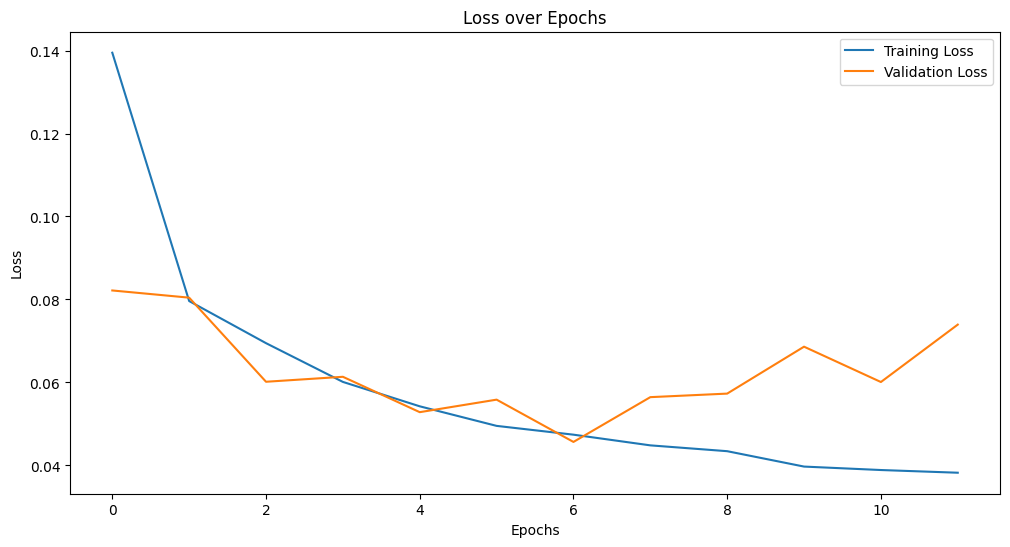

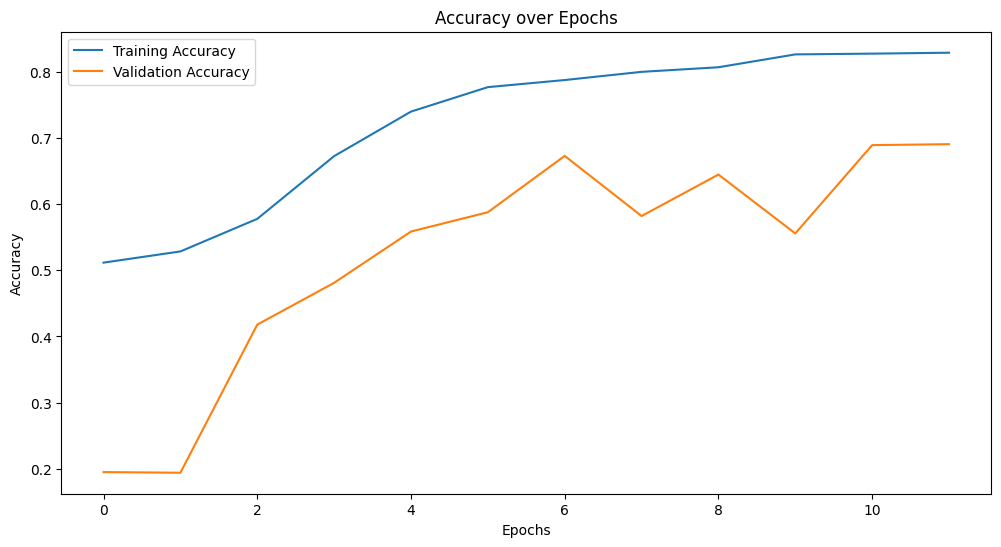

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# -------------------------
# 1. Load and preprocess datasets
# -------------------------

# Load datasets
train_data = pd.read_csv("BATADAL_dataset04.csv")
test_data = pd.read_csv("BATADAL_test_dataset.csv")

# Replace -999 with 0
train_data = train_data.replace(-999, 0)
test_data = test_data.replace(-999, 0)

# Extract and preprocess the datetime column (first column)
train_data.iloc[:, 0] = pd.to_datetime(train_data.iloc[:, 0], format="%d/%m/%y %H")
test_data.iloc[:, 0] = pd.to_datetime(test_data.iloc[:, 0], format="%d/%m/%y %H")

# Drop the datetime column (first column) and separate the label (last column)
train_labels = train_data.iloc[:, -1]  # Last column as labels
test_labels = test_data.iloc[:, -1]

train_data = train_data.iloc[:, 1:-1]  # Remove the first (datetime) and last (label) columns
test_data = test_data.iloc[:, 1:-1]

# Normalize data using training set statistics
min_val = train_data.min().min()
max_val = train_data.max().max()
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# -------------------------
# 2. Address class imbalance using SMOTE
# -------------------------

# Convert training data to arrays for SMOTE
X_train_flat = train_data.values
y_train_flat = train_labels.values

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_flat)

# Reshape training data for Transformer input
time_steps = 1  # Assuming one timestep
X_train_resampled = X_train_resampled.reshape(-1, time_steps, train_data.shape[1])
y_train_resampled = tf.keras.utils.to_categorical(y_train_resampled, num_classes=2)

# Process test data
X_test = test_data.values.reshape(-1, time_steps, test_data.shape[1])
y_test = tf.keras.utils.to_categorical(test_labels.values, num_classes=2)

# -------------------------
# 3. Define Focal Loss for imbalanced data
# -------------------------

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * y_true * K.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# -------------------------
# 4. Build Transformer Model
# -------------------------

def transformer_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Dense(64, activation="relu")(inputs)  # Positional encoding replacement
    x = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

# Instantiate the Transformer model
transformer = transformer_model((time_steps, train_data.shape[1]), num_classes=2)

# Compile the Transformer model
transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(alpha=0.25, gamma=2),
    metrics=["accuracy"]
)

# -------------------------
# 5. Train the Transformer Model
# -------------------------

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

history = transformer.fit(
    X_train_resampled,
    y_train_resampled,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    class_weight={0: 1.0, 1: 5.0},  # Higher weight for minority class
    callbacks=[early_stopping]
)

# -------------------------
# 6. Evaluate the Model
# -------------------------

# Predict on the test dataset
y_pred_probs = transformer.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
def print_stats(y_pred, y_true):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=1))
    print("Recall:", recall_score(y_true, y_pred, zero_division=1))
    print("F1 Score:", f1_score(y_true, y_pred, zero_division=1))

print_stats(y_pred, y_true)

# -------------------------
# 7. Plot Training History
# -------------------------

plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()